In [ ]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 9.3MB/s 


In [233]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchaudio as ta
import torchvision
import numpy as np
from torchsummary import torchsummary
from IPython.display import Audio
import matplotlib.pyplot as plt
import random

In [3]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Get Librispeech dataset, and some noise 

In [257]:
# train_dataset = ta.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
train_dataset = ta.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [271]:
!curl -L -o mono.zip https://github.com/indrasweb/chvoice/raw/main/mono.zip
!unzip -q mono.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   131  100   131    0     0   4225      0 --:--:-- --:--:-- --:--:--  4225
100 4482k  100 4482k    0     0  35.3M      0 --:--:-- --:--:-- --:--:-- 35.3M


## Signal Processing Utils

In [5]:
class DSP:

    def __init__(self, n_fft=254, hop_len=None):
        """ signal processing utils using torchaudio
        """
        self.n_fft = n_fft
        self.hop_len = n_fft//2 if hop_len is None else hop_len
        self.stft = ta.transforms.Spectrogram(
            n_fft=n_fft,
            hop_length=self.hop_len,
            win_length=n_fft,
            power=None
        )
        self.amplitude_to_db = ta.transforms.AmplitudeToDB()
        self.db_to_amplitude = lambda x: T.pow(T.pow(10.0, 0.1 * x), 1.)

    def sig_to_db_phase(self, sig):
        """ get dB and phase spectrograms of signal
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
        """
        # represent input signal in time-frequency domain
        stft = self.stft(sig)
        # magnitude = amount of power/volume for each phase = frequency
        mag, phase = ta.functional.magphase(stft)
        # put magnitudes on log scale
        db = self.amplitude_to_db(mag)

        return db, phase

    def db_phase_to_sig(self, db, phase):
        """ get wav signal from db and phase spectrograms.
            example usage:
                >>> sig, sr = torchaudio.load('sound.wav')
                >>> db, phase = chvoice.sig_to_db_phase(sig)
                    ... do stuff to db ...
                >>> recovered_sig = chvoice.spec_to_sig(db, phase)
        """
        # go from log scale back to linear
        mag = self.db_to_amplitude(db)
        # recover full fourier transform of signal
        real = mag * T.cos(phase)
        imaginary = mag * T.sin(phase)
        complex = T.stack((real, imaginary), dim=-1)
        # inverse fourier transform to get signal
        sig = complex.istft(
            n_fft=self.n_fft,
            hop_length=self.hop_len
        )

        return sig

## Pre-processing and augmentation

In [252]:
class Noiser:

    def __init__(self, noise_dir):
        """ add noise to signal, where noise is randomly 
            selected wav from noise_dir.
        """
        fns = os.listdir(noise_dir)
        rs = ta.transforms.Resample()
        self.noises = []
        for fn in fns:
            noise = ta.load(os.path.join(noise_dir, fn))
            rs = ta.transforms.Resample(noise[1], 16000)(noise[0])
            self.noises.append(rs.squeeze(0))
        
    def add_noise(self, sig, snr=0.2):
        """ sig is expected to be one-dimensional (N,)
            snr = signal to noise ratio 
        """
        noise = random.choice(self.noises)
        if len(noise) < len(sig):
            n_repeats = int(np.ceil(len(sig) / len(noise)))
            noise = T.repeat_interleave(noise, n_repeats)
        
        sig = sig + noise[:len(sig)]*snr
        
        return sig

In [253]:
def preprocess(X, dsp, noiser):
    clean = []
    noisy = []
    wavs = [d[0] for d in X]

    for wav in wavs:

        db, phase = dsp.sig_to_db_phase(wav)
        if db.size(2) < 128:
            continue

        # make clean chunks of audio
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        torchvision.transforms.functional.normalize(chunks, -32, 18, False)
        clean.append(chunks)

        # make corresponding noisy chunks of audio
        aug_wav = noiser.add_noise(wav.squeeze(0), np.random.random())
        db, phase = dsp.sig_to_db_phase(aug_wav.unsqueeze(0))
        chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
        chunks = normalize(chunks)
        noisy.append(chunks)

    clean = T.vstack(clean).unsqueeze(1)
    noisy = T.vstack(noisy).unsqueeze(1)
    
    return clean, noisy

## Model Definition (UNet)

In [234]:
### CREDIT : https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [256]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Train

In [238]:
dsp = DSP(254)
noiser = Noiser('mono/')

train_loader = T.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
    collate_fn=lambda x: preprocess(x, dsp, noiser),
)

model = UNet(1, 1).to(DEVICE)
optim = T.optim.Adam(model.parameters(), 4e-4)
crit = nn.MSELoss()

In [255]:
for epoch in range(1, 10):
    print(f'----- EPOCH {epoch} -----')
    for i, (clean, noisy) in enumerate(train_loader):
        clean, noisy = clean[:32,:,:,:].to(DEVICE), noisy[:32,:,:,:].to(DEVICE)
        optim.zero_grad()
        pred = model(noisy)
        loss = crit(pred, clean)
        loss.backward()
        optim.step()
        print(i, loss.item())

----- EPOCH 1 -----
0 0.7239677309989929
1 0.5537295341491699
2 0.5008519887924194
3 0.3902604579925537
4 0.2750885486602783
5 0.23813429474830627
6 0.3347129821777344
7 0.19209226965904236
8 0.21959377825260162
9 0.08857616782188416
10 0.14289671182632446
11 0.10297466069459915
12 0.21136878430843353
13 0.14110329747200012
14 0.11372093856334686
15 0.11791832745075226
16 0.18056800961494446
17 0.10099077969789505
18 0.06788907200098038
19 0.08622187376022339
20 0.06395507603883743
21 0.08929310739040375
22 0.14351916313171387
23 0.07145572453737259
24 0.31602057814598083
25 0.3053078353404999
26 0.08411958813667297
27 0.057956524193286896
28 0.1427440494298935
29 0.15471592545509338
30 0.10346735268831253
31 0.061942316591739655
32 0.07691781967878342
33 0.1605355143547058
34 0.1020042672753334
35 0.07131403684616089
36 0.08787418156862259
37 0.06603559106588364
38 0.05600578337907791
39 0.11680181324481964
40 0.15889300405979156
41 0.09080468863248825
42 0.05559324473142624
43 0.0528

KeyboardInterrupt: ignored

# Evaluate

In [222]:
denormalize = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=0., std=1/18),
    torchvision.transforms.Normalize(mean=32., std=1.)
])

def evaluate(wav, model, plot_spectrograms=True):
        
    db, phase = dsp.sig_to_db_phase(wav)

    if plot_spectrograms:
        print('dB spectrogram in')
        plt.imshow(db[0])
        plt.show()

    assert db.size(2) >= 128, 'wav too small'

    chunks = db.unfold(2, 128, 128).squeeze(0).movedim(1,0)
    chunks = normalize(chunks).unsqueeze(1).to(DEVICE)
                 
    with T.no_grad():
        proc = denormalize(model(chunks))
    
    db_out = T.cat([c for c in proc.squeeze(1)], dim=1).cpu()
    
    if plot_spectrograms:
        print('db spectrogram out')
        plt.imshow(db_out.numpy())
        plt.show()
    
    phase_clipped = phase[0,:,:db_out.size(1)]
    sig = dsp.db_phase_to_sig(db_out, phase_clipped)
    
    return sig

Load a sample, and add noise to it

In [217]:
in_sig = train_dataset[45][0]
Audio(in_sig, rate=16000)

In [218]:
wobbly = noiser.add_noise(in_sig.squeeze(0), 0.6).unsqueeze(0)
Audio(wobbly, rate=16000)

dB spectrogram in


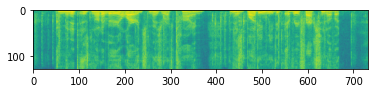

db spectrogram out


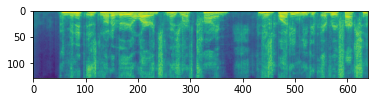

In [223]:
model = model.eval()
out_sig = evaluate(wobbly, model)
model = model.train()  # set model back to train mode
Audio(out_sig, rate=16000)